In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as optimize

In [2]:
import numpy as np

def nll(theta,t):
    f,tau1,tau2 = theta
    return -np.sum(np.log(f*(1/tau1)*np.exp(-t/tau1)+(1-f)*(1/tau2)*np.exp(-t/tau2)))  

class tcdecay_distribution:
    
    # constructors
    def __init__(self, f, tau1, tau2):
        self.f = float(f)
        self.tau1 = float(tau1)
        self.tau2 = float(tau2)
        
    # method to return exponential distribution    
    def evaluate_md(self,t):
        return self.f*(1/self.tau1)*np.exp(-t/self.tau1)+(1-self.f)*(1/self.tau2)*np.exp(-t/self.tau2)
    
    # method to return maximum value of distribution  
    def maximum(self):
        return 10.0
    
    # method to return random number with distribution
    # choose numpy random exponential or custom code 'calum'    
    def random_val(self):           
        x1 = 0.
        x2 = 0.
        x3 = 1.
        while ( x3 > x2 ):
            x1 = np.random.uniform()
            x1 = x1*7.
            x2 = self.evaluate_md(x1)
            x3 = np.random.uniform() * self.maximum()
        
        return x1
    
    # integrates area under the curve, in this example should be normalised
    # therefore always roughly equal to 1
    def numeric_integral(self,lo,hi,npoints=100000):
        
        sumf = 0
        
        for i in range(0,npoints):
            x = lo+np.random.uniform()*(hi-lo)
            sumf += self.evaluate_md(x)
            
        return sumf*(hi-lo)/npoints
    
    def nll(self,theta,t):
        f,tau1,tau2 = theta
        return -np.sum(np.log(f*(1/tau1)*np.exp(-t/tau1)+(1-f)*(1/tau2)*np.exp(-t/tau2)))  
    
    # performs an observation by taking n_muons random values
    # of the distribution
    def observation(self,n_tests=10000,method='TNC'):
        results = []
        for i in range(0,n_tests):
            results.append(self.random_val())
        
        mle_estimates = optimize.minimize(self.nll, [self.f, self.tau1, self.tau2], args=(np.array(results)),method=method)
        params = mle_estimates['x']
        # return (parameters_estimates, results)
        return params, np.array(results)

In [155]:
true_params = [0.74849409,  0.1978367 ,  1.30720393]

In [3]:
test = tcdecay_distribution(0.74849409,  0.1978367 ,  1.30720393)

In [4]:
test.numeric_integral(0,10)

0.99836607431997759

In [5]:
val, result = test.observation()  
val,result.shape

(array([ 0.72325671,  0.19008336,  1.19257345]), (10000,))

In [26]:
np.max(result)

6.9992773610430943

In [6]:
val, result = test.observation(method='Nelder-mead')  
val,result.shape

(array([ 0.7381317 ,  0.19707541,  1.27325337]), (10000,))

In [7]:
data = np.loadtxt('DecayTimesData.txt')
data.shape

(10000,)

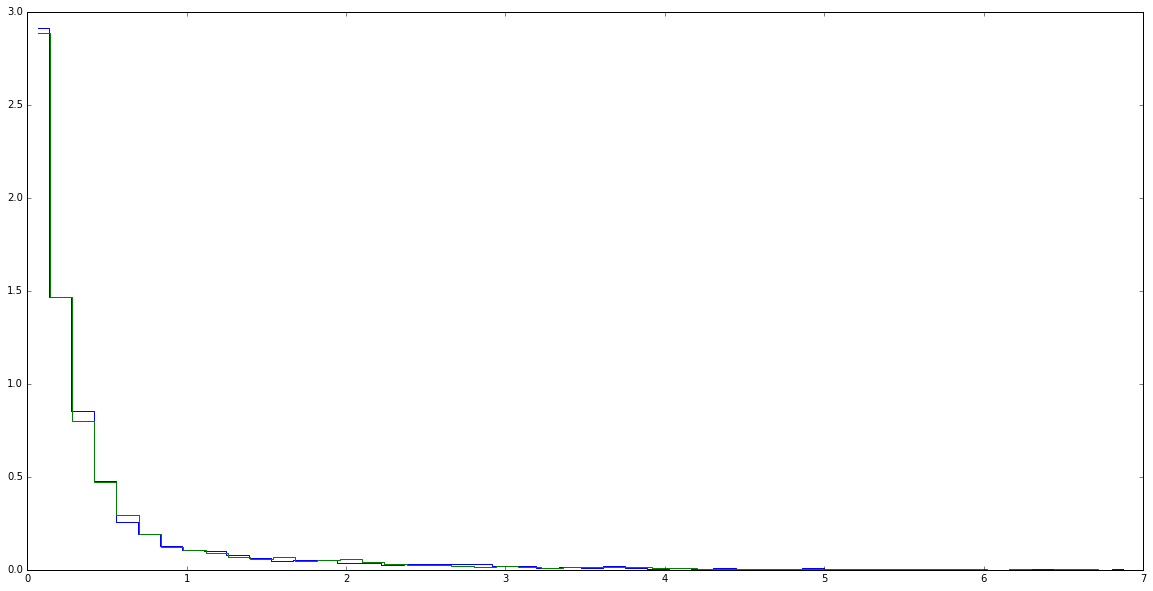

In [8]:
f,bins = np.histogram(data,bins=50,normed=True)
step = bins[1]-bins[0]
plt.figure(figsize=(20,10))
plt.plot(bins[1:]-step/2,f,drawstyle='steps-mid')
step

n, bins = np.histogram(result, bins=50, normed=True)

step = (bins[1]-bins[0])/2
plt.plot(bins[1:]-step,n,drawstyle='steps-mid')

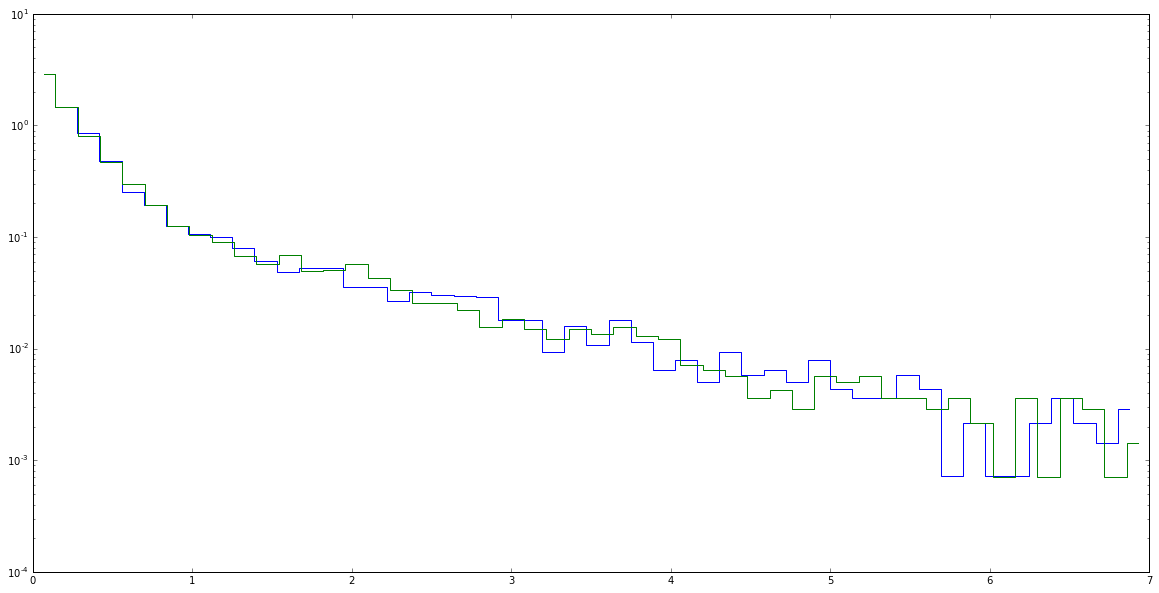

In [9]:
f,bins = np.histogram(data,bins=50,normed=True)
step = bins[1]-bins[0]
plt.figure(figsize=(20,10))
plt.plot(bins[1:]-step/2,f,drawstyle='steps-mid')
step

n, bins = np.histogram(result, bins=50, normed=True)

step = (bins[1]-bins[0])/2
plt.plot(bins[1:]-step,n,drawstyle='steps-mid')

plt.yscale('log')

test = tcdecay_distribution(0.74849409,  0.1978367 ,  1.30720393)
results = []
for _ in range(50):
    results.append(test.observation(method='Nelder-mead')[0])

In [71]:
results_tnc = np.load('/home/calum/Documents/NumRep/max_likelihood/run_sim_tnc.npy')
lresults_tnc = np.load('/home/calum/Documents/NumRep/max_likelihood/large_run_sim_tnc.npy')
results_nm = np.load('/home/calum/Documents/NumRep/max_likelihood/run_sim_nm.npy')
lresults_nm = np.load('/home/calum/Documents/NumRep/max_likelihood/large_run_sim_nm.npy')

In [72]:
np.array(results_tnc).shape, np.array(results_nm).shape

((5000, 3), (5000, 3))

In [126]:
print(np.median([row[0] for row in lresults_tnc]), np.median([row[1] for row in lresults_tnc]), np.median([row[2] for row in lresults_tnc]))
print(np.std([row[0] for row in lresults_tnc if 4 >row[0] > 0]), np.std([row[1] for row in lresults_tnc if 2 >row[0] > 0]), np.std([row[2] for row in lresults_tnc if 2 >row[0] > 0]))

0.741966801771 0.195730560796 1.24876472089
0.0283231603919 0.00375126489398 0.0343162362763


In [223]:
def plot_run(array,idx,label):
    n, bins = np.histogram(np.array([row[idx] for row in array if .95 >row[0] > .55]), bins=20, normed=True)

    step = (bins[1]-bins[0])/2
    plt.plot(bins[1:]-step-true_params[idx],n,label=label,drawstyle='steps-mid',lw=1.5)
    print(np.mean([row[idx] for row in array if 1 >row[0] > 0]),np.std([row[idx] for row in array if 1 >row[0] > 0]),
          np.median([row[idx] for row in array if 1 >row[0] > 0]))

0.741548660485 0.00927895652711 0.742027649422
0.740302086921 0.00940647518826 0.740362936108


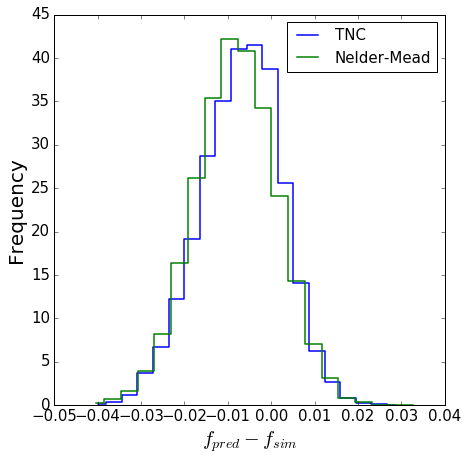

In [224]:
plt.figure(figsize=(7,7))
plot_run(lresults_tnc,0,'TNC')
plot_run(lresults_nm,0,'Nelder-Mead')
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$f_{pred}-f_{sim}$',fontsize=20)
plt.ylabel('Frequency',fontsize=20)

0.195712557901 0.00375126489398
0.195328115556 0.00378686672016


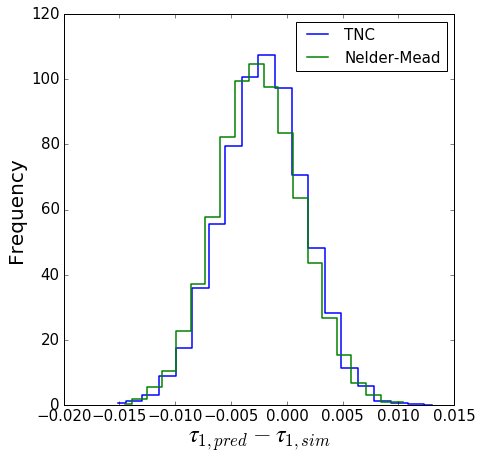

In [221]:
plt.figure(figsize=(7,7))
plot_run(lresults_tnc,1,'TNC')
plot_run(lresults_nm,1,'Nelder-Mead')
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$τ_{1,pred}-τ_{1,sim}$',fontsize=24)
plt.ylabel('Frequency',fontsize=20)

1.24876936876 0.0343162362763
1.24384724244 0.0341619093379


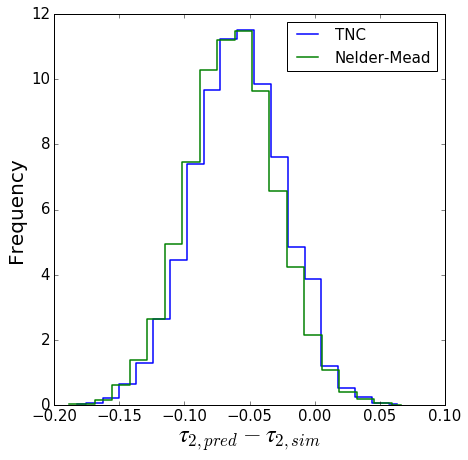

In [222]:
plt.figure(figsize=(7,7))
plot_run(lresults_tnc,2,'TNC')
plot_run(lresults_nm,2,'Nelder-Mead')
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$τ_{2,pred}-τ_{2,sim}$',fontsize=24)
plt.ylabel('Frequency',fontsize=20)

In [211]:
run100 = np.load('/home/calum/Documents/NumRep/max_likelihood/run100.npy')
run500 = np.load('/home/calum/Documents/NumRep/max_likelihood/run500.npy')
run1000 = np.load('/home/calum/Documents/NumRep/max_likelihood/run1000.npy')
run2000 = np.load('/home/calum/Documents/NumRep/max_likelihood/run2000.npy')
run10000 = np.load('/home/calum/Documents/NumRep/max_likelihood/large_run_sim_tnc.npy')

0.740986669063 0.078509570517 0.74849409
0.740275264759 0.0393316886275 0.742343397356
0.741152820942 0.0281977855716 0.742581585625
0.741258805381 0.0198276703078 0.742191435427
0.741548660485 0.00927895652711 0.742027649422


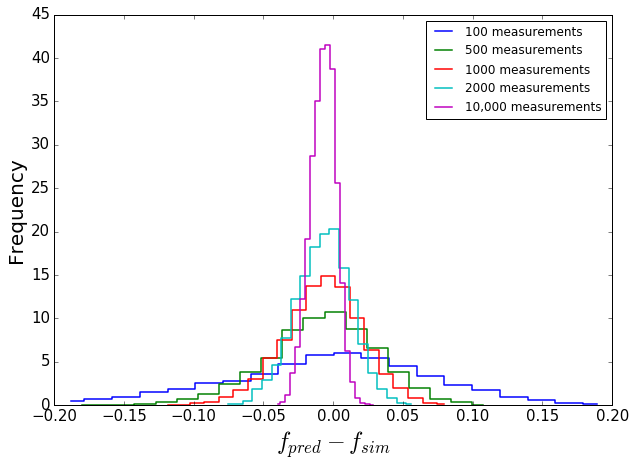

In [225]:
plt.figure(figsize=(10,7))
plot_run(run100,0,'100 measurements')
plot_run(run500,0,'500 measurements')
plot_run(run1000,0,'1000 measurements')
plot_run(run2000,0,'2000 measurements')
plot_run(run10000,0,'10,000 measurements')
plt.legend(fontsize=12)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$f_{pred}-f_{sim}$',fontsize=24)
plt.ylabel('Frequency',fontsize=20)

0.197869564389 0.0350641260109 0.196948469727
0.195638590726 0.0163884118328 0.195011075367
0.195742024266 0.0115697776321 0.195534925324
0.195687831317 0.00822337046045 0.195711117247
0.195712557901 0.00375126489398 0.195746135888


(-0.1, 0.1)

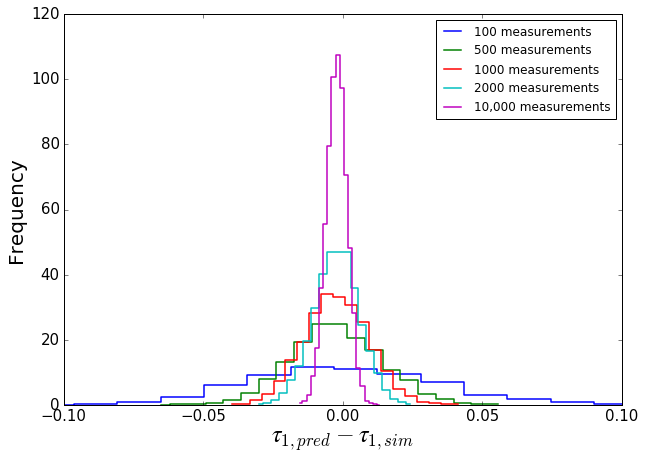

In [226]:
plt.figure(figsize=(10,7))
plot_run(run100,1,'100 measurements')
plot_run(run500,1,'500 measurements')
plot_run(run1000,1,'1000 measurements')
plot_run(run2000,1,'2000 measurements')
plot_run(run10000,1,'10,000 measurements')
plt.legend(fontsize=12)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$τ_{1,pred}-τ_{1,sim}$',fontsize=24)
plt.ylabel('Frequency',fontsize=20)
plt.xlim(-0.1,0.1)

1.28541448941 0.283136375132 1.28863965605
1.25771917682 0.140835952093 1.26116406952
1.25306437235 0.102783352467 1.25623218081
1.25016271636 0.0724862700225 1.25097608173
1.24876936876 0.0343162362763 1.24866527075


(-0.5, 0.5)

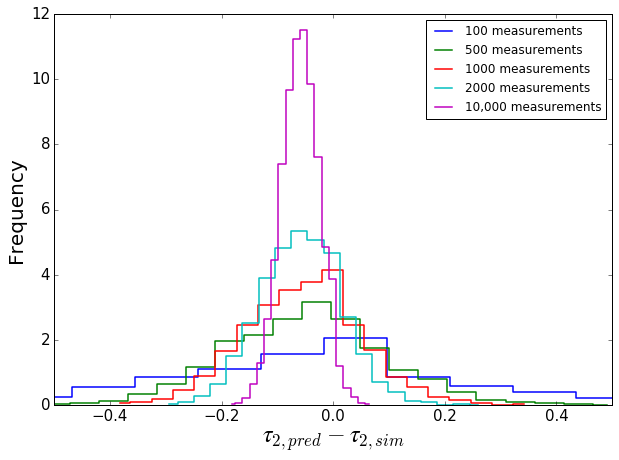

In [227]:
plt.figure(figsize=(10,7))
plot_run(run100,2,'100 measurements')
plot_run(run500,2,'500 measurements')
plot_run(run1000,2,'1000 measurements')
plot_run(run2000,2,'2000 measurements')
plot_run(run10000,2,'10,000 measurements')
plt.legend(fontsize=12)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$τ_{2,pred}-τ_{2,sim}$',fontsize=24)
plt.ylabel('Frequency',fontsize=20)
plt.xlim(-0.5,0.5)

In [234]:
hrun100 = np.load('/home/calum/Documents/NumRep/max_likelihood/height_run100.npy')
hrun500 = np.load('/home/calum/Documents/NumRep/max_likelihood/height_run500.npy')
hrun1000 = np.load('/home/calum/Documents/NumRep/max_likelihood/height_run1000.npy')
hrun2000 = np.load('/home/calum/Documents/NumRep/max_likelihood/height_run2000.npy')

0.738490509518 0.0804634365093 0.745301491465
0.742315659276 0.0402256421849 0.744029590482
0.740261260152 0.0287835628251 0.741830696224
0.741007420308 0.0200332357851 0.742146004726


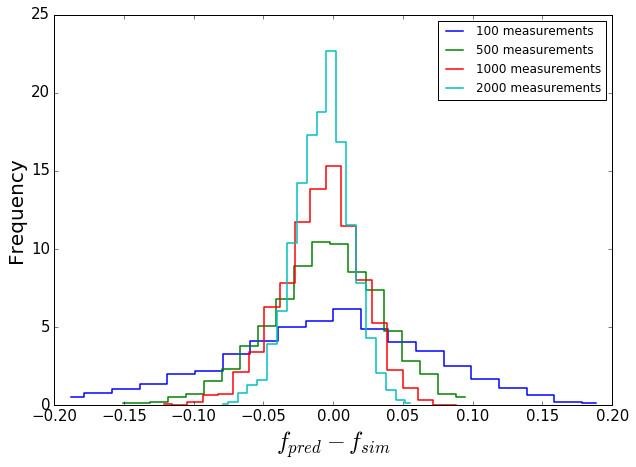

In [235]:
plt.figure(figsize=(10,7))
plot_run(hrun100,0,'100 measurements')
plot_run(hrun500,0,'500 measurements')
plot_run(hrun1000,0,'1000 measurements')
plot_run(hrun2000,0,'2000 measurements')
plt.legend(fontsize=12)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$f_{pred}-f_{sim}$',fontsize=24)
plt.ylabel('Frequency',fontsize=20)

0.195821089073 0.0357214847541 0.194888805893
0.196084369974 0.0164333395419 0.196001722049
0.195740171455 0.0119285540905 0.195510820316
0.195516869813 0.00835287626652 0.195452256325


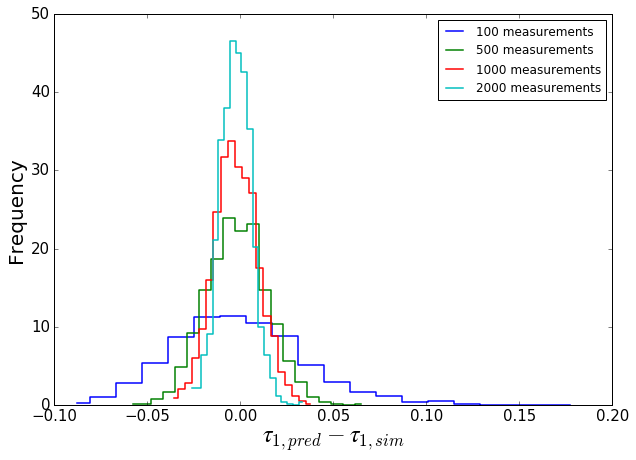

In [231]:
plt.figure(figsize=(10,7))
plot_run(hrun100,1,'100 measurements')
plot_run(hrun500,1,'500 measurements')
plot_run(hrun1000,1,'1000 measurements')
plot_run(hrun2000,1,'2000 measurements')
plt.legend(fontsize=12)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$τ_{1,pred}-τ_{1,sim}$',fontsize=24)
plt.ylabel('Frequency',fontsize=20)

1.2838621102 0.282466855615 1.29312490346
1.25793897059 0.141260530331 1.26045630451
1.2536271474 0.101612049815 1.25504573473
1.24816196942 0.0751563005902 1.24694077678


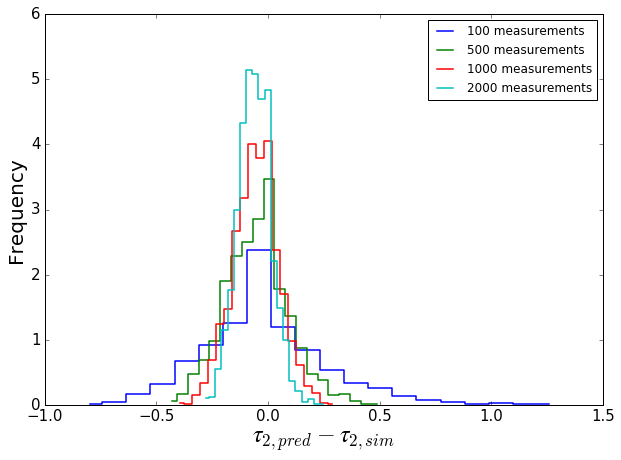

In [233]:
plt.figure(figsize=(10,7))
plot_run(hrun100,2,'100 measurements')
plot_run(hrun500,2,'500 measurements')
plot_run(hrun1000,2,'1000 measurements')
plot_run(hrun2000,2,'2000 measurements')
plt.legend(fontsize=12)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$τ_{2,pred}-τ_{2,sim}$',fontsize=24)
plt.ylabel('Frequency',fontsize=20)

In [240]:
frun100 = np.load('/home/calum/Documents/NumRep/max_likelihood/fin_run100.npy')
frun500 = np.load('/home/calum/Documents/NumRep/max_likelihood/fin_run500.npy')
frun1000 = np.load('/home/calum/Documents/NumRep/max_likelihood/fin_run1000.npy')
#frun2000 = np.load('/home/calum/Documents/NumRep/max_likelihood/fin_run2000.npy')

1.28192332666 0.28074076691 1.28647007653
1.25485579199 0.144537769939 1.25904217751
1.25520759621 0.104823858585 1.25107061671


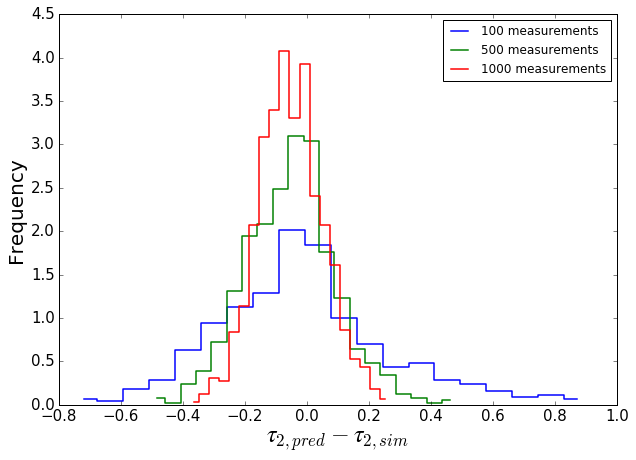

In [241]:
plt.figure(figsize=(10,7))
plot_run(frun100,2,'100 measurements')
plot_run(frun500,2,'500 measurements')
plot_run(frun1000,2,'1000 measurements')
#plot_run(frun2000,2,'2000 measurements')
plt.legend(fontsize=12)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$τ_{2,pred}-τ_{2,sim}$',fontsize=24)
plt.ylabel('Frequency',fontsize=20)